# Churn Prediction

- Binary classification

$$g(x_{i}) \approx y_{i}$$

$$y_{i} \in \{0, 1\}$$

- $1$: Churn
- $0$: No Churn

**Dataset**:

[telco-customer-churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)


Install packages


In [1]:
!uv pip install -q \
    python-dotenv==1.2.1 \
    pandas==2.3.2 \
    pandas-stubs==2.3.2.250827 \
    numpy==2.3.2 \
    matplotlib==3.10.6 \
    seaborn==0.13.2 \
    scikit-learn==1.7.1

Append notebooks directory to sys.path


In [ ]:
import sys

sys.path.append("../../..")

Import packages


In [3]:
import os
import pathlib
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple
import numpy as np
from numpy.typing import NDArray
import seaborn as sns
import datetime
from collections import Counter
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from notebooks.python.utils.data_extraction.data_extraction import (
    KaggleDataExtractor,
    KaggleExtractionConfig,
)

pd.set_option("display.max_columns", None)

sns.set_style("darkgrid")
sns.set_theme(style="darkgrid")

%matplotlib inline

load_dotenv()  # Root directory .env file

True

## Utility scripts:

**KaggleDataExtractor**:

```py
--8<-- "docs/notebooks/python/utils/data_extraction/data_extraction.py"
```


Create data directory


In [ ]:
DATA_DIR = pathlib.Path("data/predicting-customer-churn")

os.makedirs(DATA_DIR, exist_ok=True)

Download dataset from Kaggle


In [ ]:
username = os.getenv("KAGGLE_USERNAME")
api_token = os.getenv("KAGGLE_API_TOKEN")
file_name = "WA_Fn-UseC_-Telco-Customer-Churn.csv"

extractor = KaggleDataExtractor(username=username, api_token=api_token)

config = KaggleExtractionConfig(
    dataset_slug="blastchar/telco-customer-churn",
    file_name=file_name,
    destination_path=DATA_DIR,
    output_file_name="churn.csv",
)

if not os.path.isfile(DATA_DIR / "churn.csv"):
    extractor.download_dataset(config)

## Data Preparation


Load dataset


In [ ]:
df = pd.read_csv(DATA_DIR / "churn.csv")

df.head(n=2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


Inspect all columns at once


In [ ]:
df.head(3).T

,0,1,2
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK
gender,Female,Male,Male
SeniorCitizen,0,0,0
Partner,Yes,No,No
Dependents,No,No,No
tenure,1,34,2
PhoneService,No,Yes,Yes
MultipleLines,No phone service,No,No
InternetService,DSL,DSL,DSL
OnlineSecurity,No,Yes,Yes


In [ ]:
df_summary = pd.DataFrame(
    {
        "column": df.columns,
        "dtype": [df[col].dtype for col in df.columns],
        "sample_unique": [df[col].unique()[:6] for col in df.columns],
        "n_unique": [df[col].nunique() for col in df.columns],
    }
)
df_summary

,column,dtype,sample_unique,n_unique
0,customerID,object,"[7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC...",7043
1,gender,object,"[Female, Male]",2
2,SeniorCitizen,int64,"[0, 1]",2
3,Partner,object,"[Yes, No]",2
4,Dependents,object,"[No, Yes]",2
5,tenure,int64,"[1, 34, 2, 45, 8, 22]",73
6,PhoneService,object,"[No, Yes]",2
7,MultipleLines,object,"[No phone service, No, Yes]",3
8,InternetService,object,"[DSL, Fiber optic, No]",3
9,OnlineSecurity,object,"[No, Yes, No internet service]",3


Clean column names


In [ ]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

df.head(n=2)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


Select only object type columns


In [ ]:
object_type_columns = list(df.dtypes[df.dtypes == "object"].index)
object_type_columns

['customerid',
 'gender',
 'partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod',
 'totalcharges',
 'churn']

Clean columns


In [ ]:
object_type_columns = list(df.dtypes[df.dtypes == "object"].index)
for column in object_type_columns:
    df[column] = df[column].str.lower().str.replace(" ", "_")

Inspect values of total charges, it should numeric


In [ ]:
df.totalcharges[:5]

0      29.85
1     1889.5
2     108.15
3    1840.75
4     151.65
Name: totalcharges, dtype: object

Cast total charges to numeric type


In [ ]:
total_charges = pd.to_numeric(df.totalcharges, errors="coerce")
total_charges[:5]

0      29.85
1    1889.50
2     108.15
3    1840.75
4     151.65
Name: totalcharges, dtype: float64

Check for null values


In [ ]:
total_charges.loc[total_charges.isnull()][:5]

488    NaN
753    NaN
936    NaN
1082   NaN
1340   NaN
Name: totalcharges, dtype: float64

Treat the null values


In [ ]:
df.totalcharges = total_charges.fillna(0)

Check churn field values


In [ ]:
df.churn[:5]

0     no
1     no
2    yes
3     no
4    yes
Name: churn, dtype: object

Encode churn field to binary


In [ ]:
(df.churn == "yes").astype(int)[:5]

0    0
1    0
2    1
3    0
4    1
Name: churn, dtype: int64

Set original churn dataset column to binary


In [ ]:
df.churn = (df.churn == "yes").astype(int)

## Validation Framework


Set split sizes

- Training dataset: 60%
- Validation dataset: 20%
- Test dataset: 20%


Split dataset into full train (train + validation) and test


In [ ]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

Get dataset's sizes


In [ ]:
len(df_full_train), len(df_test)

(5634, 1409)

Calculate how train and validation dataset's sizes should be


In [ ]:
print(
    f"df_full_train size: {(100 - 20)/100.:.0%}\n"
    f"df_test size: {(20)/100.:.0%}\n"
    f"df_train size: 60% of 80% = {(60)/80.:.0%}\n"
    f"df_validation size: 20% of 80% = {(20)/80.:.0%}\n"
)

df_full_train size: 80%
df_test size: 20%
df_train size: 60% of 80% = 75%
df_validation size: 20% of 80% = 25%



Split full train dataset into train and validation datasets


In [ ]:
df_train, df_validation = train_test_split(
    df_full_train, test_size=0.25, random_state=1
)

Get full length of dataset


In [ ]:
len(df_train), len(df_validation), len(df_test)

(4225, 1409, 1409)

Reset dataset's indexes


In [ ]:
df_train.reset_index(drop=True, inplace=True)
df_validation.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

Get target variables


In [ ]:
y_train = df_train["churn"]
y_validation = df_validation["churn"]
y_test = df_test["churn"]

Remove target variables from original datasets


In [ ]:
df_train.drop(columns=["churn"], inplace=True)
df_validation.drop(columns=["churn"], inplace=True)
df_test.drop(columns=["churn"], inplace=True)

## Exploratory Data Analysis


Reset full train dataset index


In [ ]:
df_full_train.reset_index(drop=True, inplace=True)

Inspect dataset


In [ ]:
df_full_train.head(n=2)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.7,258.35,0
1,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,yes,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.9,3160.55,1


Check if null values are present


In [ ]:
df.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

Inspect target variable churn


In [ ]:
df_full_train.churn.value_counts()

churn
0    4113
1    1521
Name: count, dtype: int64

Get percent of total


In [ ]:
df_full_train.churn.value_counts(normalize=True)

churn
0    0.730032
1    0.269968
Name: proportion, dtype: float64

Get mean


In [ ]:
df_full_train.churn.mean()  # number of ones divided by total

np.float64(0.26996805111821087)

Mean and percent of total for churn is the same because is encoded to binary. So both calculations are _number of ones divided by total_


In [ ]:
global_churn_rate = df_full_train.churn.mean()
round(global_churn_rate, 2)

np.float64(0.27)

Inspect columns types


In [ ]:
df_full_train.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int64
dtype: object

Set numerical columns


In [ ]:
numerical_columns = ["tenure", "monthlycharges", "totalcharges"]

Set categorical columns


In [ ]:
categorical_columns = [
    "gender",
    "seniorcitizen",
    "partner",
    "dependents",
    "phoneservice",
    "multiplelines",
    "internetservice",
    "onlinesecurity",
    "onlinebackup",
    "deviceprotection",
    "techsupport",
    "streamingtv",
    "streamingmovies",
    "contract",
    "paperlessbilling",
    "paymentmethod",
]

Inspect categorical columns


In [ ]:
df_full_train[categorical_columns].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

## Feature Importance

### Churn Rate

**Difference**:

- (global_churn_rate - group_churn_rate) > 0: Less likely to churn
- (global_churn_rate - group_churn_rate) < 0: More likely to churn

**Risk Ratio**:

- (group_churn_rate / global_churn_rate) > 1: More likely to churn
- (group_churn_rate / global_churn_rate) < 1: Less likely to churn


In [ ]:
df_groups = []

for column in categorical_columns:
    global_churn_rate = df_full_train.churn.mean()
    df_group = (
        df_full_train[[column, "churn"]]
        .groupby(column)
        .churn.agg(["mean", "count"])
    )
    df_group["diff"] = df_group["mean"] - global_churn_rate
    df_group["risk"] = df_group["mean"] / global_churn_rate
    df_group = df_group.reset_index().rename(columns={column: "label"})
    df_group.insert(0, "column", column)
    df_groups.append(df_group)

result = pd.concat(df_groups, ignore_index=True)
result

,column,label,mean,count,diff,risk
0,gender,female,0.276824,2796,0.006856,1.025396
1,gender,male,0.263214,2838,-0.006755,0.974980
2,seniorcitizen,0,0.242270,4722,-0.027698,0.897403
3,seniorcitizen,1,0.413377,912,0.143409,1.531208
4,partner,no,0.329809,2932,0.059841,1.221659
5,partner,yes,0.205033,2702,-0.064935,0.759472
6,dependents,no,0.313760,3968,0.043792,1.162212
7,dependents,yes,0.165666,1666,-0.104302,0.613651
8,phoneservice,no,0.241316,547,-0.028652,0.893870
9,phoneservice,yes,0.273049,5087,0.003081,1.011412


### Mutual information

Measure importance for categorical features

How much We can learn about one variable if we know the value of another


In [ ]:
df_full_train[categorical_columns].apply(
    lambda col: mutual_info_score(col, df_full_train["churn"])
).sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

### Correlation

Measure importance for numerical features

- Positive correlation: both variables increase together
- Negative correlation: When a variable increase other decrease


In [ ]:
df_full_train[numerical_columns].corrwith(df_full_train.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

## One-hot encoding

Encode categorical features


In [ ]:
train_dicts = df_train[categorical_columns + numerical_columns].to_dict(
    orient="records"
)

dict_vectorizer = DictVectorizer(sparse=False)

X_train = dict_vectorizer.fit_transform(train_dicts)
X_train.shape

(4225, 45)

In [ ]:
validation_dicts = df_validation[
    categorical_columns + numerical_columns
].to_dict(orient="records")

X_validation = dict_vectorizer.transform(validation_dicts)
X_validation.shape

(1409, 45)

## Logistic Regression

$$g(x_{i}) = sigmoid(w_{j} + W^{t}x_{i})$$

- Linear regression return a number between -$\infty$ and +$\infty$
- Logistic regression return a number between 0 and 1, due the usage of sigmoid function

### Regression

- Linear: gives a score
- Logistic: transform the score into a probability

### Classification

- Binary
- Multiclass


Sigmoid function


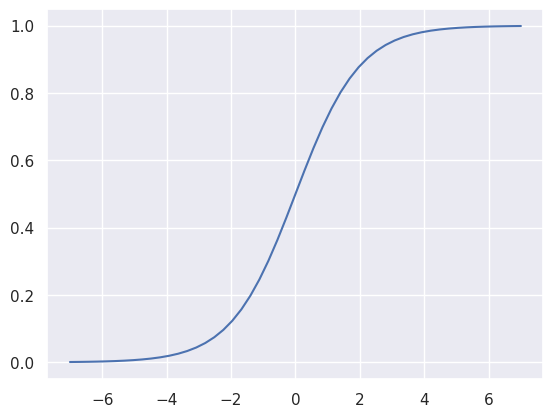

In [ ]:
def sigmoid(z: NDArray[np.float64]) -> NDArray[np.float64]:
    return 1 / (1 + np.exp(-z))


z = np.linspace(-7, 7, 51)


plt.plot(z, sigmoid(z))
plt.show()

Linear regression formula


In [ ]:
def linear_regression(xi: NDArray[np.float64]) -> float:
    score = weight0

    for index in range(len(weights)):
        # linear operator (dot product)
        score = score + xi[index] * weights[index]

    return score

Logistic regression formula


In [ ]:
def logistic_regression(xi: NDArray[np.float64]) -> float:
    score = weight0

    for index in range(len(weights)):
        # linear operator (dot product)
        score = score + xi[index] * weights[index]

    result = sigmoid(score)
    return score

## Training a logistic regression model


In [ ]:
model = LogisticRegression(max_iter=9999)
model.fit(X_train, y_train)

print(
    model.intercept_[0],  # bias term
    model.coef_[0].round(3),  # w (weights)
)

-0.04544302938501822 [ 0.686  0.032 -0.678  0.055 -0.015  0.113 -0.16   0.087  0.039  0.001
 -0.498  0.698 -0.16  -0.018 -0.188  0.068  0.159  0.117 -0.16   0.083
  0.284 -0.16  -0.085 -0.161  0.201 -0.044  0.084 -0.053 -0.002  0.107
 -0.011  0.068 -0.028  0.195 -0.095 -0.16   0.295 -0.055 -0.16   0.255
  0.234 -0.16  -0.034 -0.068  0.   ]


Probability of a customer churn without we knowing anything about it


In [ ]:
sigmoid(model.intercept_[0])  # w0 (bias therm)

np.float64(0.4886411973123377)

In [ ]:
# model.predict(X_train) # Label
y_pred = model.predict_proba(X_validation)[:, 1]  # Probability
y_pred

array([0.00666591, 0.2048263 , 0.21770395, ..., 0.15156007, 0.78870418,
       0.81191834], shape=(1409,))

In [ ]:
churn_decision = y_pred >= 0.5

Customers that may churn


In [ ]:
df_validation[churn_decision].head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
3,8433-wxgna,male,0,no,no,2,yes,no,fiber_optic,yes,no,no,no,no,no,month-to-month,yes,electronic_check,75.70,189.20
8,3440-jpscl,female,0,no,no,6,yes,no,fiber_optic,no,no,yes,yes,yes,yes,month-to-month,yes,mailed_check,99.95,547.65
12,7228-omtpn,male,0,no,no,4,yes,no,fiber_optic,no,no,no,no,yes,yes,month-to-month,yes,electronic_check,88.45,370.65
19,6711-fldfb,female,0,no,no,7,yes,yes,fiber_optic,no,no,no,no,no,no,month-to-month,yes,electronic_check,74.90,541.15
24,2612-ranwt,female,0,no,no,12,yes,yes,fiber_optic,no,no,yes,no,yes,yes,month-to-month,yes,bank_transfer_(automatic),100.15,1164.30


In [ ]:
(y_validation == churn_decision).mean()

np.float64(0.8034066713981547)

Doing verification step by step


In [ ]:
df_pred = pd.DataFrame()
df_pred["probability"] = y_pred
df_pred["prediction"] = churn_decision.astype(int)
df_pred["actual"] = y_validation
df_pred["correct"] = df_pred.prediction == df_pred.actual
df_pred.head()

,probability,prediction,actual,correct
0,0.006666,0,0,True
1,0.204826,0,0,True
2,0.217704,0,0,True
3,0.563754,1,1,True
4,0.218419,0,0,True


In [ ]:
df_pred.correct.mean()

np.float64(0.8034066713981547)

## Model interpretation

- Using a smaller model (trained with less features) and multiplying the values for their weights to reach the predicted value is an easier approach


Understand weights for each feature


In [ ]:
pd.DataFrame(
    list(
        zip(dict_vectorizer.get_feature_names_out(), model.coef_[0].round(3))
    ),
    columns=["feature", "coefficient"],
).sort_values(by=["coefficient"], ascending=False).head(10)

,feature,coefficient
11,internetservice=fiber_optic,0.698
0,contract=month-to-month,0.686
36,streamingmovies=yes,0.295
20,onlinesecurity=no,0.284
39,streamingtv=yes,0.255
40,techsupport=no,0.234
24,paperlessbilling=yes,0.201
33,seniorcitizen,0.195
16,multiplelines=yes,0.159
17,onlinebackup=no,0.117


In [ ]:
small_model_features = ["contract", "tenure", "monthlycharges"]
df_train[small_model_features].head()

,contract,tenure,monthlycharges
0,two_year,72,115.50
1,month-to-month,10,95.25
2,month-to-month,5,75.55
3,month-to-month,5,80.85
4,two_year,18,20.10


Encode features


In [ ]:
dicts_train_small = df_train[small_model_features].to_dict(orient="records")
dicts_validation_small = df_validation[small_model_features].to_dict(
    orient="records"
)

dict_vectorizer_small = DictVectorizer(sparse=False)
dict_vectorizer_small.fit(dicts_train_small)

dict_vectorizer_small.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'monthlycharges', 'tenure'], dtype=object)

Train model to get coefficients


In [ ]:
X_train_small = dict_vectorizer_small.transform(dicts_train_small)

model_small = LogisticRegression()
model_small.fit(X_train_small, y_train)

w0 = model_small.intercept_[0]
w = model_small.coef_[0]

w0, w

(np.float64(-2.477957595284362),
 array([ 0.9711394 , -0.02379507, -0.94828863,  0.02748534, -0.03619005]))

Inspect coefficients


In [ ]:
small_coefficients = dict(
    zip(
        dict_vectorizer_small.get_feature_names_out(),
        model_small.coef_[0].round(3),
    )
)

small_coefficients

{'contract=month-to-month': np.float64(0.971),
 'contract=one_year': np.float64(-0.024),
 'contract=two_year': np.float64(-0.948),
 'monthlycharges': np.float64(0.027),
 'tenure': np.float64(-0.036)}

Calculate the result for a customer:

- month to month contract
- $50 of monthly charges
- 5 months that the customer has been with the company


Probability of churn


In [ ]:
contract = (
    1 * small_coefficients["contract=month-to-month"]
    + 0 * small_coefficients["contract=one_year"]
    + 0 * small_coefficients["contract=two_year"]
)
monthly_charges = 50 * small_coefficients["monthlycharges"]
tenure = 5 * small_coefficients["tenure"]

sigmoid(model_small.intercept_[0] + contract + monthly_charges + tenure)

np.float64(0.41654870232071844)

## Using the model


Train the model with complete dataset


In [ ]:
# Encode full train dataset features
dicts_full_train = df_full_train[
    categorical_columns + numerical_columns
].to_dict(orient="records")

dicts_vectorizer_full_train = DictVectorizer(sparse=False)
X_full_train = dicts_vectorizer_full_train.fit_transform(dicts_full_train)

# Train model
y_full_train = df_full_train.churn.values
model = LogisticRegression(max_iter=99999)
model.fit(X_full_train, y_full_train)

# Encode test dataset features
dicts_test = df_test[categorical_columns + numerical_columns].to_dict(
    orient="records"
)
X_test = dicts_vectorizer_full_train.transform(dicts_test)

# Predict results
y_pred = model.predict_proba(X_test)[:, 1]
churn_decision = y_pred >= 0.5
churn_decision[:5]

array([False, False, False, False, False])

Model accuracy


In [ ]:
(churn_decision == y_test).mean()

np.float64(0.8097941802696949)

In [ ]:
customer_data = dicts_test[10]
customer_data

{'gender': 'male',
 'seniorcitizen': 1,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'no',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'no',
 'onlinebackup': 'yes',
 'deviceprotection': 'no',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'mailed_check',
 'tenure': 32,
 'monthlycharges': 93.95,
 'totalcharges': 2861.45}

Encode customer features to prediction


In [ ]:
X_customer = dicts_vectorizer_full_train.transform([customer_data])
X_customer.shape  # 1 customer, 45 features

(1, 45)

Predict customer churn


In [ ]:
model.predict_proba(X_customer)[:, 1]

array([0.47693536])

when probability < 0.5, is more likely that customer will not churn


Confirm the actual label


In [ ]:
y_test[10]

np.int64(0)

## Evaluation

### Accuracy

- Evaluate the model on different thresholds


In [ ]:
thresholds = np.linspace(0, 1, 21)

scores = []

for threshold in thresholds:
    score = accuracy_score(y_test, y_pred >= threshold)
    print(f"{threshold:.2f}", f"{score:.2f}")
    scores.append(score)

0.00 0.25
0.05 0.51
0.10 0.62
0.15 0.67
0.20 0.71
0.25 0.74
0.30 0.76
0.35 0.77
0.40 0.79
0.45 0.80
0.50 0.81
0.55 0.82
0.60 0.81
0.65 0.81
0.70 0.79
0.75 0.77
0.80 0.76
0.85 0.75
0.90 0.75
0.95 0.75
1.00 0.75


In [ ]:
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

Check class imbalance


In [ ]:
df_full_train.churn.value_counts()

churn
0    4113
1    1521
Name: count, dtype: int64

If we have a class with a lot more values than another, this is called class imbalanced, and the accuracy measure can be misleading for this cases because is calculation is:

$$\frac{number\_correct\_predictions}{total\_predictions}$$

We must have a way to identify if our model is good besides _class imbalance_


### Confusion Table

| True Negative          | False Negative   | False Positive         | True Positive    |
| ---------------------- | ---------------- | ---------------------- | ---------------- |
| No Churn               | No Churn         | Churn                  | Churn            |
| Customer did not churn | Customer churned | Customer did not churn | Customer Churned |
| Correct                | Wrong            | Wrong                  | Correct          |


Building a confusion matrix


In [ ]:
actual_positive = y_test == 1
actual_negative = y_test == 0

confusion_threshold = 0.5

predict_positive = y_pred >= confusion_threshold
predict_negative = y_pred < confusion_threshold

true_positive = (predict_positive & actual_positive).sum()
true_negative = (predict_negative & actual_negative).sum()
false_positive = (predict_positive & actual_negative).sum()
false_negative = (predict_negative & actual_positive).sum()

confusion_matrix = np.array(
    [[true_negative, false_positive], [false_negative, true_positive]]
)

confusion_matrix

array([[937, 124],
       [144, 204]])

Getting the accuracy from confusion matrix


In [ ]:
accuracy = (true_positive + true_negative) / (
    true_positive + true_negative + false_positive + false_negative
)

accuracy

np.float64(0.8097941802696949)

### Precision and Recall

**Precision**:

Fraction of positive predictions (customers that will churn) that are correct

$$\frac{true\_positives}{true\_positives + false\_positives}$$


In [ ]:
precision = true_positive / (true_positive + false_positive)
print(
    f"Precision: From those we predicted would churn only {precision:.2f} actually would\n",
    f"Wrongly said that would churn: {1.0 - precision:.2f}",
)

Precision: From those we predicted would churn only 0.62 actually would
 Wrongly said that would churn: 0.38


**Recall**:

Fraction correctly identified positive examples

$$\frac{true\_positives}{true\_positives + false\_negatives}$$


In [ ]:
recall = true_positive / (true_positive + false_negative)
print(
    f"Recall: From the customer that would actually churn {recall:.2f} customers were predicted to\n",
    f"Failed to identify churning customers: {1.0 - recall:.2f}",
)

Recall: From the customer that would actually churn 0.59 customers were predicted to
 Failed to identify churning customers: 0.41


### ROC Curves

_Receiver Operating Characteristics_

Is a way to describe the performance of a binary classification model


TPR (true positive rate)


In [ ]:
true_positive_rate = true_positive / (true_positive + false_negative)
true_positive_rate

np.float64(0.5862068965517241)

FPR (false positive rate)


In [ ]:
false_positive_rate = false_positive / (true_positive + false_negative)
false_positive_rate

np.float64(0.3563218390804598)

Evaluate different confusion matrixes for each threshold


In [ ]:
scores = []

thresholds = np.linspace(0, 1, 101)

for threshold in thresholds:
    actual_positive = y_test == 1
    actual_negative = y_test == 0

    predict_positive = y_pred >= threshold
    predict_negative = y_pred < threshold

    true_positive = (predict_positive & actual_positive).sum()
    true_negative = (predict_negative & actual_negative).sum()
    false_positive = (predict_positive & actual_negative).sum()
    false_negative = (predict_negative & actual_positive).sum()

    scores.append(
        (
            threshold,
            true_positive,
            false_positive,
            false_negative,
            true_negative,
        )
    )

Visualize values in a DataFrame


In [ ]:
df_scores = pd.DataFrame(
    scores,
    columns=[
        "threshold",
        "true_positive",
        "false_positive",
        "false_negative",
        "true_negative",
    ],
)

df_scores["true_positive_rate"] = df_scores.true_positive / (
    df_scores.true_positive + df_scores.false_negative
)

df_scores["false_positive_rate"] = df_scores.false_positive / (
    df_scores.false_positive + df_scores.true_negative
)

df_scores[::10]

,threshold,true_positive,false_positive,false_negative,true_negative,true_positive_rate,false_positive_rate
0,0.0,348,1061,0,0,1.000000,1.000000
10,0.1,336,529,12,532,0.965517,0.498586
20,0.2,314,379,34,682,0.902299,0.357210
30,0.3,280,269,68,792,0.804598,0.253534
40,0.4,247,194,101,867,0.709770,0.182846
50,0.5,204,124,144,937,0.586207,0.116871
60,0.6,148,62,200,999,0.425287,0.058435
70,0.7,72,18,276,1043,0.206897,0.016965
80,0.8,8,0,340,1061,0.022989,0.000000
90,0.9,0,0,348,1061,0.000000,0.000000


Plot _true positive rates_ and _true negative rates_


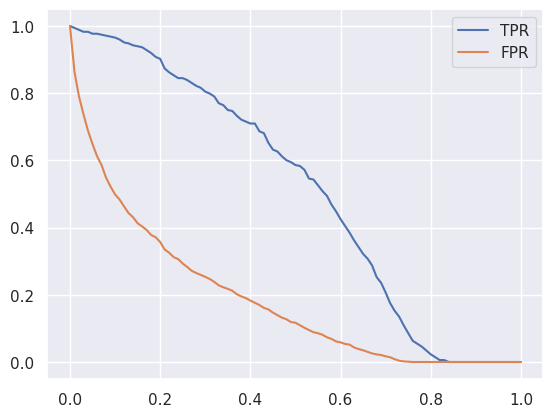

In [86]:
plt.plot(df_scores.threshold, df_scores.true_positive_rate, label="TPR")
plt.plot(df_scores.threshold, df_scores.false_positive_rate, label="FPR")
plt.legend()
plt.show()